# DBSCAN Clustering on Grafana Logs

This notebook applies DBSCAN (Density-Based Spatial Clustering of Applications with Noise) to Grafana logs.

DBSCAN is particularly useful for:
- Finding clusters of arbitrary shape
- Identifying outliers/noise points (potential anomalies)
- Not requiring the number of clusters to be specified beforehand

## Steps:
1. Load feature matrix
2. Determine optimal parameters (eps and min_samples)
3. Apply DBSCAN clustering
4. Evaluate clustering quality
5. Analyze noise points (outliers)
6. Visualize clusters
7. Analyze cluster characteristics
8. Benchmark performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score, normalized_mutual_info_score,
    homogeneity_score, completeness_score, v_measure_score
)
from sklearn.decomposition import PCA
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

In [2]:
# Load feature matrix (scaled version)
X = pd.read_csv('../data/feature_matrix_scaled.csv')
metadata = pd.read_csv('../data/metadata.csv')

print(f"Feature matrix shape: {X.shape}")
print(f"Metadata shape: {metadata.shape}")
print(f"\nAnomaly distribution:")
print(metadata['is_anomaly'].value_counts())

Feature matrix shape: (149999, 45)
Metadata shape: (149999, 6)

Anomaly distribution:
is_anomaly
False    119999
True      30000
Name: count, dtype: int64


## 2. Determine Optimal Parameters

### Finding optimal eps using k-distance graph

Using 5000 samples for parameter tuning...
Estimated min_samples: 9


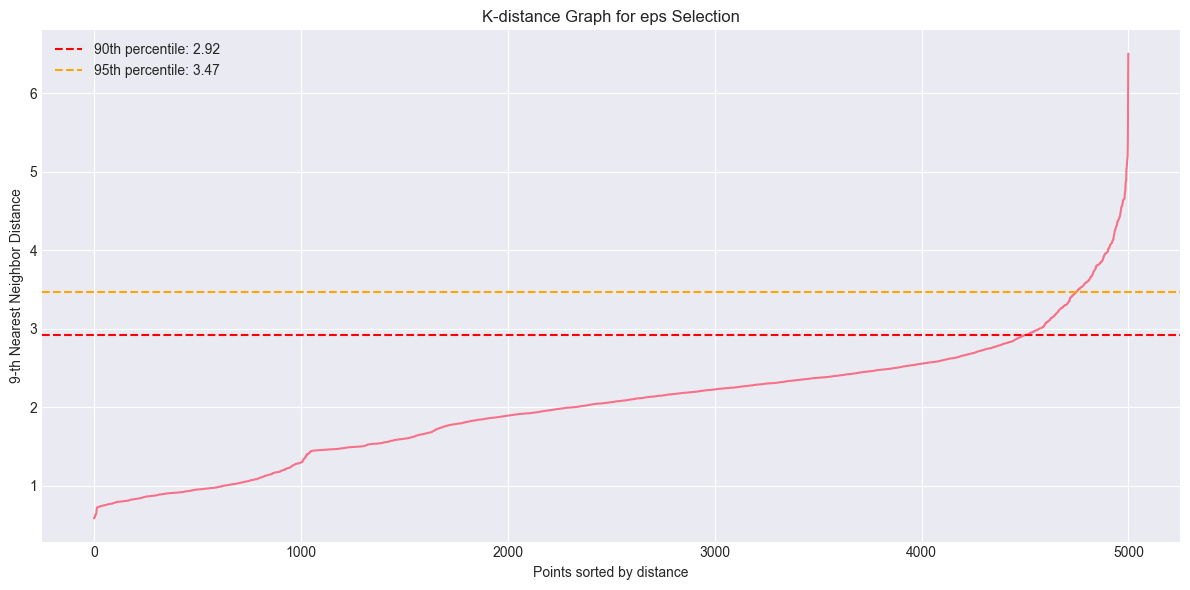


Suggested eps (90th percentile): 2.92
Suggested eps (95th percentile): 3.47


In [3]:
# Use a sample for parameter tuning (DBSCAN can be slow on large datasets)
sample_size = min(5000, len(X))
sample_indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X.iloc[sample_indices]

print(f"Using {sample_size} samples for parameter tuning...")

# Compute k-nearest neighbors for k-distance graph
# Rule of thumb: min_samples = 2 * dimensions or min_samples = 4
# We'll start with min_samples = 2 * n_features or a reasonable value
min_samples_estimate = min(10, max(4, X.shape[1] // 5))
print(f"Estimated min_samples: {min_samples_estimate}")

# Find k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=min_samples_estimate)
neighbors_fit = neighbors.fit(X_sample)
distances, indices = neighbors_fit.kneighbors(X_sample)

# Sort distances
distances = np.sort(distances[:, -1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{min_samples_estimate}-th Nearest Neighbor Distance')
plt.title('K-distance Graph for eps Selection')
plt.grid(True)
plt.axhline(y=np.percentile(distances, 90), color='r', linestyle='--', 
            label=f'90th percentile: {np.percentile(distances, 90):.2f}')
plt.axhline(y=np.percentile(distances, 95), color='orange', linestyle='--', 
            label=f'95th percentile: {np.percentile(distances, 95):.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Suggest eps values
suggested_eps = np.percentile(distances, 90)
print(f"\nSuggested eps (90th percentile): {suggested_eps:.2f}")
print(f"Suggested eps (95th percentile): {np.percentile(distances, 95):.2f}")

## 3. Parameter Grid Search

In [4]:
# Test different parameter combinations
eps_values = np.linspace(suggested_eps * 0.5, suggested_eps * 2.0, 5)
min_samples_values = [4, 6, 8, 10]

results = []

print("Testing DBSCAN parameter combinations...\n")

for eps in eps_values:
    for min_samples in min_samples_values:
        print(f"Testing eps={eps:.2f}, min_samples={min_samples}...", end=' ')
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(X_sample)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        result = {
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise / len(labels)
        }
        
        # Only calculate metrics if we have at least 2 clusters
        if n_clusters >= 2:
            # Filter out noise points for metric calculation
            mask = labels != -1
            if mask.sum() > 0:
                try:
                    result['silhouette'] = silhouette_score(X_sample[mask], labels[mask])
                    result['davies_bouldin'] = davies_bouldin_score(X_sample[mask], labels[mask])
                    result['calinski_harabasz'] = calinski_harabasz_score(X_sample[mask], labels[mask])
                except:
                    result['silhouette'] = -999
                    result['davies_bouldin'] = 999
                    result['calinski_harabasz'] = 0
            else:
                result['silhouette'] = -999
                result['davies_bouldin'] = 999
                result['calinski_harabasz'] = 0
        else:
            result['silhouette'] = -999
            result['davies_bouldin'] = 999
            result['calinski_harabasz'] = 0
        
        results.append(result)
        print(f"Clusters: {n_clusters}, Noise: {n_noise} ({result['noise_ratio']*100:.1f}%)")

results_df = pd.DataFrame(results)
print("\nParameter search complete!")

Testing DBSCAN parameter combinations...

Testing eps=1.46, min_samples=4... Clusters: 429, Noise: 1286 (25.7%)
Testing eps=1.46, min_samples=6... Clusters: 258, Noise: 2222 (44.4%)
Testing eps=1.46, min_samples=8... Clusters: 141, Noise: 3100 (62.0%)
Testing eps=1.46, min_samples=10... Clusters: 89, Noise: 3668 (73.4%)
Testing eps=2.55, min_samples=4... Clusters: 88, Noise: 232 (4.6%)
Testing eps=2.55, min_samples=6... Clusters: 74, Noise: 348 (7.0%)
Testing eps=2.55, min_samples=8... Clusters: 74, Noise: 441 (8.8%)
Testing eps=2.55, min_samples=10... Clusters: 67, Noise: 594 (11.9%)
Testing eps=3.65, min_samples=4... Clusters: 18, Noise: 19 (0.4%)
Testing eps=3.65, min_samples=6... Clusters: 17, Noise: 43 (0.9%)
Testing eps=3.65, min_samples=8... Clusters: 15, Noise: 66 (1.3%)
Testing eps=3.65, min_samples=10... Clusters: 15, Noise: 89 (1.8%)
Testing eps=4.74, min_samples=4... Clusters: 4, Noise: 3 (0.1%)
Testing eps=4.74, min_samples=6... Clusters: 4, Noise: 3 (0.1%)
Testing eps=4.7

In [5]:
# Display results
print("\nDBSCAN Parameter Search Results:")
print(results_df.to_string(index=False))

# Find best parameters
valid_results = results_df[results_df['silhouette'] > -999]
if len(valid_results) > 0:
    best_idx = valid_results['silhouette'].idxmax()
    best_params = results_df.loc[best_idx]
    
    print(f"\nBest parameters (by Silhouette):")
    print(f"  eps: {best_params['eps']:.2f}")
    print(f"  min_samples: {int(best_params['min_samples'])}")
    print(f"  n_clusters: {int(best_params['n_clusters'])}")
    print(f"  noise_ratio: {best_params['noise_ratio']*100:.1f}%")
    print(f"  silhouette: {best_params['silhouette']:.4f}")
else:
    print("\nNo valid clustering found. Using default parameters.")
    best_params = {'eps': suggested_eps, 'min_samples': min_samples_estimate}


DBSCAN Parameter Search Results:
     eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette  davies_bouldin  calinski_harabasz
1.459170            4         429     1286       0.2572    0.480945        0.765615         245.330296
1.459170            6         258     2222       0.4444    0.506253        0.740407         308.319522
1.459170            8         141     3100       0.6200    0.511549        0.750059         342.232179
1.459170           10          89     3668       0.7336    0.535013        0.704244         379.928325
2.553547            4          88      232       0.0464    0.219230        1.390171         223.669029
2.553547            6          74      348       0.0696    0.224967        1.402180         255.997655
2.553547            8          74      441       0.0882    0.227623        1.399596         252.393085
2.553547           10          67      594       0.1188    0.229993        1.419185         267.105154
3.647924            4          18      

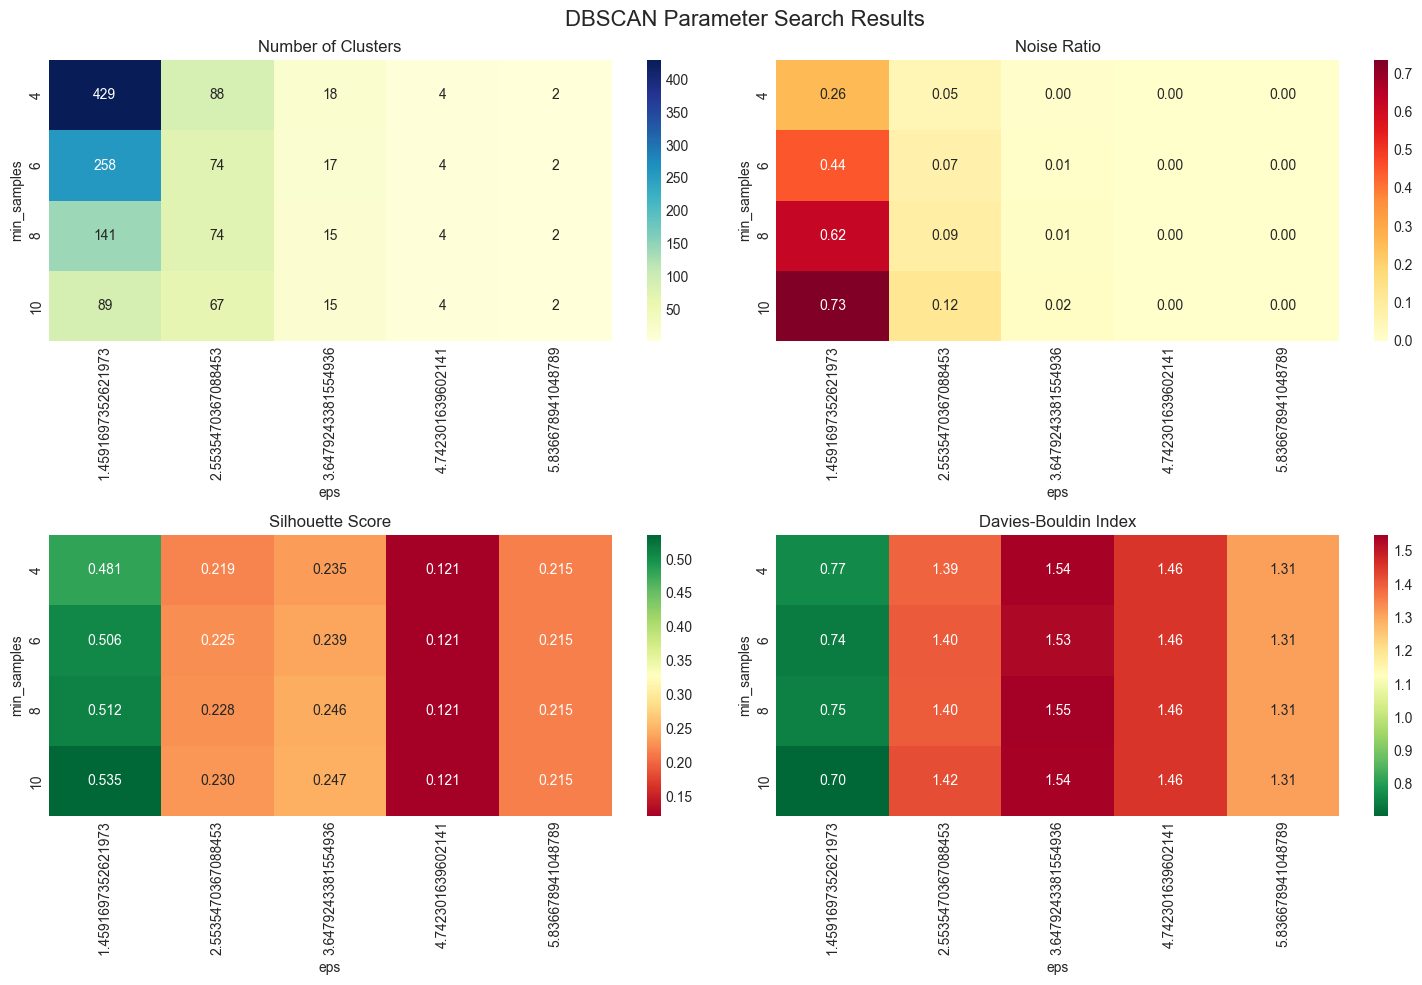

In [6]:
# Visualize parameter search results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('DBSCAN Parameter Search Results', fontsize=16)

# Number of clusters
pivot1 = results_df.pivot(index='min_samples', columns='eps', values='n_clusters')
sns.heatmap(pivot1, annot=True, fmt='.0f', cmap='YlGnBu', ax=axes[0, 0])
axes[0, 0].set_title('Number of Clusters')

# Noise ratio
pivot2 = results_df.pivot(index='min_samples', columns='eps', values='noise_ratio')
sns.heatmap(pivot2, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[0, 1])
axes[0, 1].set_title('Noise Ratio')

# Silhouette score
pivot3 = results_df.pivot(index='min_samples', columns='eps', values='silhouette')
# Replace -999 with NaN for better visualization
pivot3 = pivot3.replace(-999, np.nan)
sns.heatmap(pivot3, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1, 0])
axes[1, 0].set_title('Silhouette Score')

# Davies-Bouldin Index
pivot4 = results_df.pivot(index='min_samples', columns='eps', values='davies_bouldin')
pivot4 = pivot4.replace(999, np.nan)
sns.heatmap(pivot4, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=axes[1, 1])
axes[1, 1].set_title('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

## 4. Apply DBSCAN with Optimal Parameters

In [7]:
# Use best parameters on full dataset
optimal_eps = best_params['eps']
optimal_min_samples = int(best_params['min_samples'])

print(f"Applying DBSCAN with eps={optimal_eps:.2f}, min_samples={optimal_min_samples}")

# Benchmark DBSCAN performance
start_time = time.time()

dbscan_final = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples, n_jobs=-1)
cluster_labels = dbscan_final.fit_predict(X)

training_time = time.time() - start_time

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"\nDBSCAN completed in {training_time:.2f} seconds")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise:,} ({n_noise/len(cluster_labels)*100:.1f}%)")
print(f"\nCluster distribution:")
print(pd.Series(cluster_labels).value_counts().sort_index())

Applying DBSCAN with eps=1.46, min_samples=10

DBSCAN completed in 108.05 seconds
Number of clusters: 609
Number of noise points: 4,678 (3.1%)

Cluster distribution:
-1      4678
 0       648
 1       635
 2       655
 3       631
        ... 
 604      11
 605      11
 606      13
 607      16
 608      10
Name: count, Length: 610, dtype: int64


## 5. Evaluate Clustering Quality

In [8]:
# Calculate metrics (excluding noise points)
mask = cluster_labels != -1
X_clustered = X[mask]
labels_clustered = cluster_labels[mask]

print("="*80)
print("DBSCAN CLUSTERING EVALUATION METRICS")
print("="*80)
print(f"eps: {optimal_eps:.2f}")
print(f"min_samples: {optimal_min_samples}")
print(f"Training time: {training_time:.2f} seconds")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise:,} ({n_noise/len(cluster_labels)*100:.1f}%)")

if n_clusters >= 2 and len(X_clustered) > 0:
    silhouette_avg = silhouette_score(X_clustered, labels_clustered)
    davies_bouldin = davies_bouldin_score(X_clustered, labels_clustered)
    calinski_harabasz = calinski_harabasz_score(X_clustered, labels_clustered)
    
    print(f"\nInternal Validation Metrics (excluding noise):")
    print(f"  - Silhouette Score: {silhouette_avg:.4f} (range: [-1, 1], higher is better)")
    print(f"  - Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)")
    print(f"  - Calinski-Harabasz Score: {calinski_harabasz:.2f} (higher is better)")
else:
    print("\nNot enough clusters for metric calculation.")
    silhouette_avg = -999
    davies_bouldin = 999
    calinski_harabasz = 0

# External validation (if true labels available)
if 'is_anomaly' in metadata.columns:
    true_labels = metadata['is_anomaly'].values
    
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    homogeneity = homogeneity_score(true_labels, cluster_labels)
    completeness = completeness_score(true_labels, cluster_labels)
    v_measure = v_measure_score(true_labels, cluster_labels)
    
    print(f"\nExternal Validation Metrics (vs. anomaly labels):")
    print(f"  - Adjusted Rand Index: {ari:.4f} (range: [-1, 1], higher is better)")
    print(f"  - Normalized Mutual Information: {nmi:.4f} (range: [0, 1], higher is better)")
    print(f"  - Homogeneity: {homogeneity:.4f} (range: [0, 1], higher is better)")
    print(f"  - Completeness: {completeness:.4f} (range: [0, 1], higher is better)")
    print(f"  - V-measure: {v_measure:.4f} (range: [0, 1], higher is better)")
    
    # Analyze noise points as anomalies
    noise_mask = cluster_labels == -1
    noise_anomaly_rate = metadata[noise_mask]['is_anomaly'].mean() * 100
    non_noise_anomaly_rate = metadata[~noise_mask]['is_anomaly'].mean() * 100
    
    print(f"\nNoise Points Analysis:")
    print(f"  - Anomaly rate in noise points: {noise_anomaly_rate:.2f}%")
    print(f"  - Anomaly rate in clustered points: {non_noise_anomaly_rate:.2f}%")
    print(f"  - Noise points are {noise_anomaly_rate/non_noise_anomaly_rate:.2f}x more likely to be anomalies")

print("="*80)

DBSCAN CLUSTERING EVALUATION METRICS
eps: 1.46
min_samples: 10
Training time: 108.05 seconds
Number of clusters: 609
Number of noise points: 4,678 (3.1%)

Internal Validation Metrics (excluding noise):
  - Silhouette Score: 0.3297 (range: [-1, 1], higher is better)
  - Davies-Bouldin Index: 1.3279 (lower is better)
  - Calinski-Harabasz Score: 3197.11 (higher is better)

External Validation Metrics (vs. anomaly labels):
  - Adjusted Rand Index: 0.0035 (range: [-1, 1], higher is better)
  - Normalized Mutual Information: 0.1541 (range: [0, 1], higher is better)
  - Homogeneity: 0.9989 (range: [0, 1], higher is better)
  - Completeness: 0.0835 (range: [0, 1], higher is better)
  - V-measure: 0.1541 (range: [0, 1], higher is better)

Noise Points Analysis:
  - Anomaly rate in noise points: 99.74%
  - Anomaly rate in clustered points: 17.43%
  - Noise points are 5.72x more likely to be anomalies


## 6. Visualize Clusters (PCA)

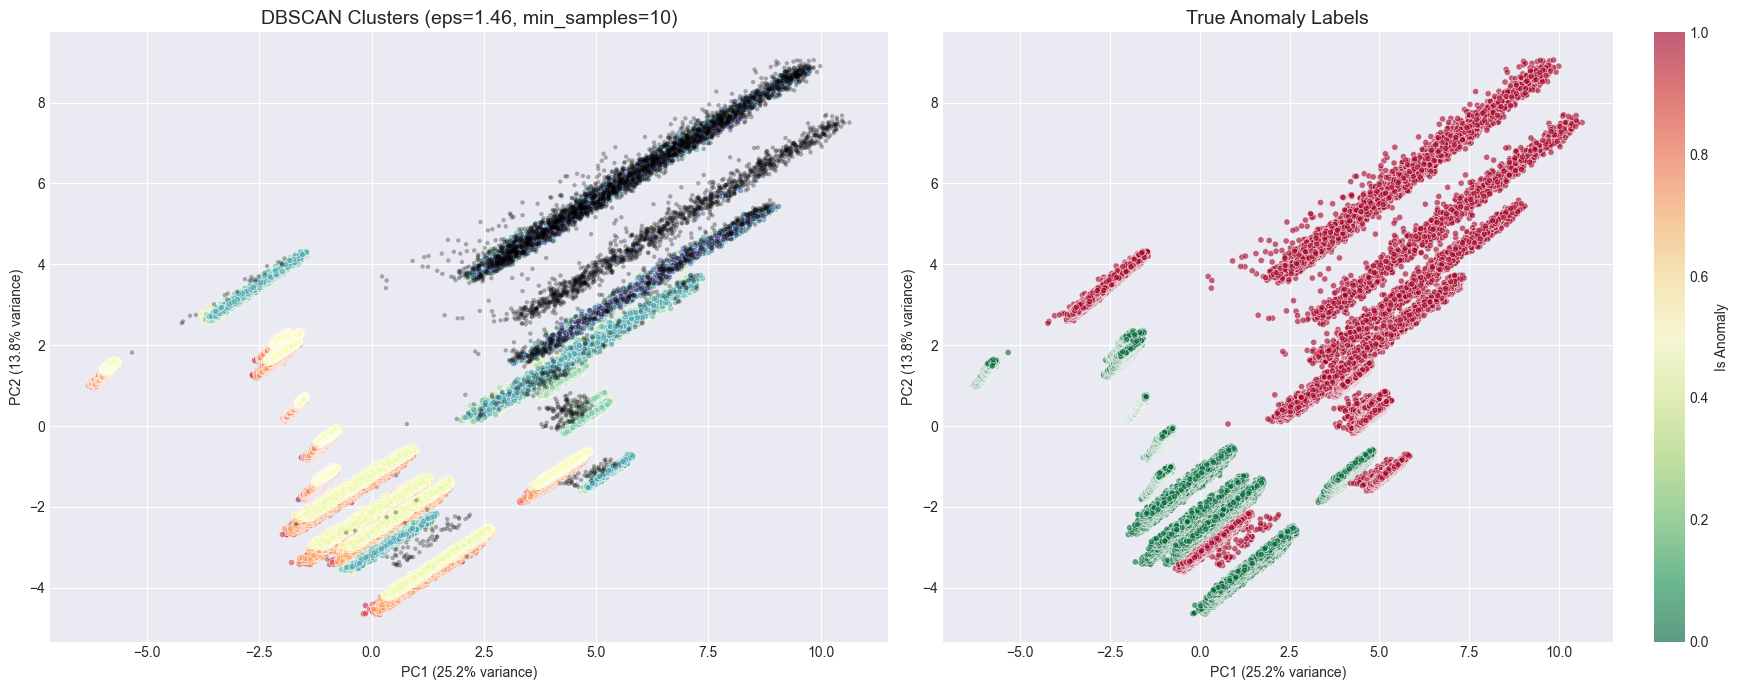

In [9]:
# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot clusters (noise points in black)
unique_labels = set(cluster_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'black'
    
    class_member_mask = (cluster_labels == k)
    xy = X_pca[class_member_mask]
    
    if k == -1:
        axes[0].scatter(xy[:, 0], xy[:, 1], c=[col], alpha=0.3, s=10, 
                       edgecolors='none', label='Noise')
    else:
        axes[0].scatter(xy[:, 0], xy[:, 1], c=[col], alpha=0.6, s=20, 
                       edgecolors='w', linewidth=0.5, label=f'Cluster {k}')

axes[0].set_title(f'DBSCAN Clusters (eps={optimal_eps:.2f}, min_samples={optimal_min_samples})', fontsize=14)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
if n_clusters <= 10:
    axes[0].legend(loc='best', markerscale=2)

# Plot true anomaly labels if available
if 'is_anomaly' in metadata.columns:
    scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                               c=metadata['is_anomaly'], cmap='RdYlGn_r', 
                               alpha=0.6, s=20, edgecolors='w', linewidth=0.5)
    axes[1].set_title('True Anomaly Labels', fontsize=14)
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    plt.colorbar(scatter2, ax=axes[1], label='Is Anomaly')

plt.tight_layout()
plt.show()

## 7. Cluster Characteristics Analysis

In [10]:
# Add cluster labels to metadata
metadata['dbscan_cluster'] = cluster_labels

# Analyze clusters (including noise as cluster -1)
print("CLUSTER CHARACTERISTICS")
print("="*80)

for cluster_id in sorted(set(cluster_labels)):
    cluster_mask = metadata['dbscan_cluster'] == cluster_id
    cluster_data = metadata[cluster_mask]
    
    if cluster_id == -1:
        print(f"\nNoise Points (Outliers):")
    else:
        print(f"\nCluster {cluster_id}:")
    
    print(f"  Size: {len(cluster_data):,} ({len(cluster_data)/len(metadata)*100:.1f}%)")
    
    if 'is_anomaly' in metadata.columns:
        anomaly_rate = cluster_data['is_anomaly'].mean() * 100
        print(f"  Anomaly rate: {anomaly_rate:.2f}%")
    
    if len(cluster_data) > 0 and cluster_id != -1:
        print(f"  Top services:")
        print(cluster_data['service'].value_counts().head(3))
        
        print(f"  Top panels:")
        print(cluster_data['panel'].value_counts().head(3))

CLUSTER CHARACTERISTICS

Noise Points (Outliers):
  Size: 4,678 (3.1%)
  Anomaly rate: 99.74%

Cluster 0:
  Size: 648 (0.4%)
  Anomaly rate: 0.00%
  Top services:
service
api-gateway    648
Name: count, dtype: int64
  Top panels:
panel
Cache Hit Rate    648
Name: count, dtype: int64

Cluster 1:
  Size: 635 (0.4%)
  Anomaly rate: 0.00%
  Top services:
service
analytics-service    635
Name: count, dtype: int64
  Top panels:
panel
GC Time    635
Name: count, dtype: int64

Cluster 2:
  Size: 655 (0.4%)
  Anomaly rate: 0.00%
  Top services:
service
product-service    655
Name: count, dtype: int64
  Top panels:
panel
Memory Usage    655
Name: count, dtype: int64

Cluster 3:
  Size: 631 (0.4%)
  Anomaly rate: 0.00%
  Top services:
service
payment-service    631
Name: count, dtype: int64
  Top panels:
panel
Query Duration    631
Name: count, dtype: int64

Cluster 4:
  Size: 1,235 (0.8%)
  Anomaly rate: 0.00%
  Top services:
service
analytics-service    1235
Name: count, dtype: int64
  Top pane

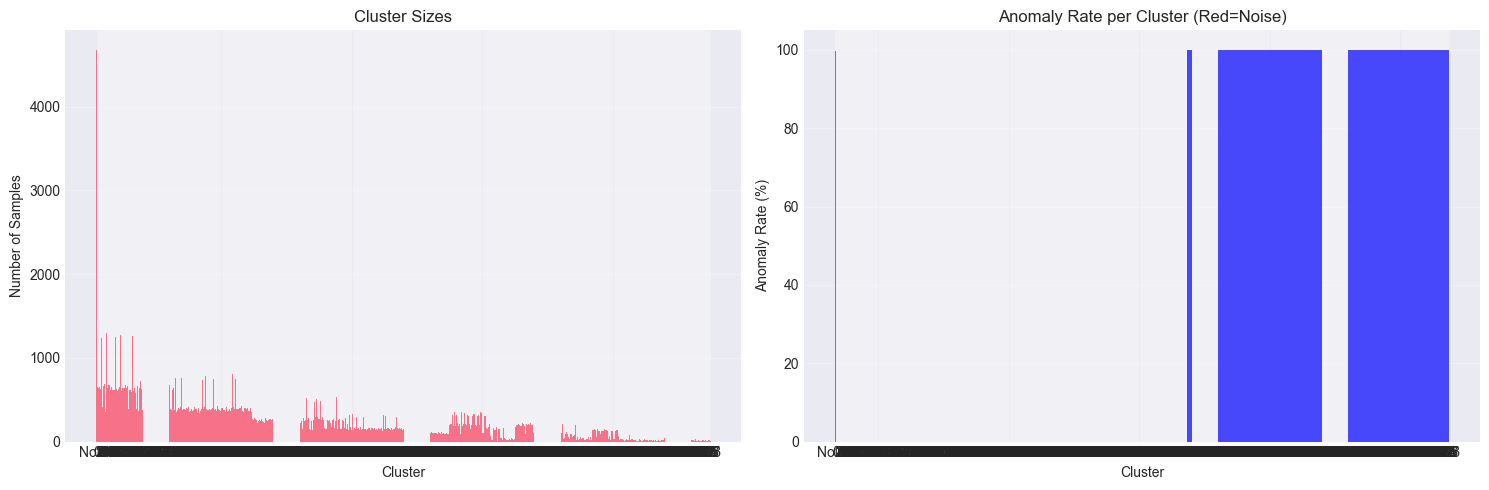

In [11]:
# Visualize cluster characteristics
if 'is_anomaly' in metadata.columns:
    # Anomaly distribution per cluster
    cluster_anomaly = metadata.groupby('dbscan_cluster')['is_anomaly'].agg(['sum', 'count', 'mean'])
    cluster_anomaly['anomaly_rate'] = cluster_anomaly['mean'] * 100
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Cluster sizes
    cluster_ids = cluster_anomaly.index
    axes[0].bar(range(len(cluster_ids)), cluster_anomaly['count'])
    axes[0].set_xticks(range(len(cluster_ids)))
    axes[0].set_xticklabels([f'{int(i)}' if i != -1 else 'Noise' for i in cluster_ids])
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Number of Samples')
    axes[0].set_title('Cluster Sizes')
    axes[0].grid(True, alpha=0.3)
    
    # Anomaly rates
    colors = ['red' if i == -1 else 'blue' for i in cluster_ids]
    axes[1].bar(range(len(cluster_ids)), cluster_anomaly['anomaly_rate'], 
               color=colors, alpha=0.7)
    axes[1].set_xticks(range(len(cluster_ids)))
    axes[1].set_xticklabels([f'{int(i)}' if i != -1 else 'Noise' for i in cluster_ids])
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Anomaly Rate (%)')
    axes[1].set_title('Anomaly Rate per Cluster (Red=Noise)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Save Results

In [12]:
# Save cluster labels
metadata.to_csv('../data/dbscan_results.csv', index=False)
print("DBSCAN results saved!")

# Save metrics
metrics = {
    'algorithm': 'DBSCAN',
    'eps': optimal_eps,
    'min_samples': optimal_min_samples,
    'n_clusters': n_clusters,
    'n_noise': n_noise,
    'noise_ratio': n_noise / len(cluster_labels),
    'training_time': training_time,
    'silhouette_score': silhouette_avg if silhouette_avg != -999 else None,
    'davies_bouldin_index': davies_bouldin if davies_bouldin != 999 else None,
    'calinski_harabasz_score': calinski_harabasz if calinski_harabasz != 0 else None
}

if 'is_anomaly' in metadata.columns:
    metrics.update({
        'adjusted_rand_index': ari,
        'normalized_mutual_info': nmi,
        'homogeneity': homogeneity,
        'completeness': completeness,
        'v_measure': v_measure,
        'noise_anomaly_rate': noise_anomaly_rate,
        'non_noise_anomaly_rate': non_noise_anomaly_rate
    })

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('../data/dbscan_metrics.csv', index=False)
print("DBSCAN metrics saved!")

# Save parameter search results
results_df.to_csv('../data/dbscan_parameter_search.csv', index=False)
print("Parameter search results saved!")

print("\nDBSCAN clustering complete!")

DBSCAN results saved!
DBSCAN metrics saved!
Parameter search results saved!

DBSCAN clustering complete!
